In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model
import tensorflow as tf
from keras import backend as K
from keras.layers import Dense, SimpleRNN, GRU, Input, Reshape
from keras.models import Model, load_model
from keras import optimizers
from keras.callbacks import History, Callback, ModelCheckpoint, LearningRateScheduler
from study_utils import train_generator, validation_generator, prediction_generator
from sklearn.metrics import confusion_matrix, accuracy_score

Using TensorFlow backend.


In [2]:
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

In [3]:
#NUM_CLASS = 2

# image size
IMG_W = 320
IMG_H = 320
IMG_C = 3

# train image paths and their int_class
train_img_paths = np.array(open('MURA-v1.1/train_image_paths.csv', 'r').readlines())
train_img_studies = np.array(open('MURA-v1.1/train_image_studies.csv', 'r').readlines()).astype(int)
train_img_embeds = np.load('train_img_embeds64.npy')

# validation image paths and their int_class
valid_img_paths = np.array(open('MURA-v1.1/valid_image_paths.csv', 'r').readlines())
valid_img_studies = np.array(open('MURA-v1.1/valid_image_studies.csv', 'r').readlines()).astype(int)
valid_img_embeds = np.load('valid_img_embeds64.npy')

In [4]:
BATCH_SIZE = 8
units = 64

In [5]:
s = reset_tf_session() # reseting the session to avoid memory problem

In [6]:
# creating the base pre-trained model
base_model = load_model('embed_model64.hdf5')

# add a global spatial average pooling layer
X = base_model.output
#reshaping the output for gru
X = Reshape((1, -1))(X)
#input for initial state
batch_img_embeds = Input(shape=(units,), name='state_input_1')
# recurrent layer
X = GRU(units, dropout=0.2)(X, initial_state = batch_img_embeds)
# add a logistic layer
Y = Dense(1, activation='sigmoid', name='dense_2')(X)

# defining the model
model = Model(inputs=[base_model.input, batch_img_embeds], outputs=Y)

In [7]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 zero_padding2d_1
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_2
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

In [8]:
# for setting which layers to be trained
for layer in model.layers:
    layer.trainable = True

In [9]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.batch_val_losses.append(logs.get('val_loss'))
        self.batch_val_acc.append(logs.get('val_acc'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [12]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'prediction_densenet_model2_{epoch:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# s = reset_tf_session()
# last_finished_epoch = 2
# model = load_model(model_filename.format(epoch=last_finished_epoch)

In [17]:
def lr_scheduler(epoch):
    lrate = 0.001
    return lrate*(0.1**(int(epoch/2)))

In [14]:
lrate = 0.001
adam = optimizers.Adam(lrate, amsgrad=True)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [18]:
# fit model
batch_history = LossHistory()
history = History()
model.fit_generator(train_generator(train_img_paths, train_img_studies, train_img_embeds, BATCH_SIZE), 
                    steps_per_epoch = len(train_img_studies)/BATCH_SIZE,
                    epochs = 5,
                    validation_data = validation_generator(valid_img_paths, valid_img_studies, valid_img_embeds,
                                                           BATCH_SIZE),
                    validation_steps = len(valid_img_studies)/BATCH_SIZE,
                    callbacks = [history, ModelCheckpoint(model_filename), batch_history, LearningRateScheduler(lr_scheduler)],
                    initial_epoch = last_finished_epoch or 0)

Epoch 1/5
5763/5762 [==============================] - 6165s 1s/step - loss: 0.4974 - acc: 0.7669 - val_loss: 0.5375 - val_acc: 0.7238


c:\program files\python35\lib\site-packages\keras\engine\topology.py:2379: UserWarning: Layer gru_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'state_input_1:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Epoch 2/5
5763/5762 [==============================] - 6256s 1s/step - loss: 0.4737 - acc: 0.7824 - val_loss: 0.5341 - val_acc: 0.7457
Epoch 3/5
 708/5762 [==>...........................] - ETA: 1:24:56 - loss: 0.4617 - acc: 0.7883

KeyboardInterrupt: 

In [19]:
batch_loss = open('prediction_batch_losses_densenet2.txt', 'w')
for loss in batch_history.losses:
    batch_loss.write(str(loss)+'\n')
    
batch_acc = open('prediction_batch_acc_densenet2.txt', 'w')
for acc in batch_history.acc:
    batch_acc.write(str(acc)+'\n')
    
batch_loss.close()
batch_acc.close()

In [20]:
val_loss = open('prediction_val_losses_densenet2.txt', 'w')
for loss in batch_history.val_losses:
    val_loss.write(str(loss)+'\n')

val_acc = open('prediction_val_acc_densenet2.txt', 'w')
for acc in batch_history.val_acc:
    val_acc.write(str(acc)+'\n')

batch_val_loss = open('prediction_batch_val_losses_densenet2.txt', 'w')
for loss in batch_history.batch_val_losses:
    val_loss.write(str(loss)+'\n')

batch_val_acc = open('prediction_batch_val_acc_densenet2.txt', 'w')
for acc in batch_history.batch_val_acc:
    val_acc.write(str(acc)+'\n')

val_loss.close()
val_acc.close()
batch_val_acc.close()
batch_val_loss.close()

In [21]:
import json
with open('prediction_epoch_metrics_densenet2.json', 'w') as f:
    json.dump(history.history, f)

In [22]:
pred_y = model.predict_generator(prediction_generator(valid_img_paths, valid_img_embeds, BATCH_SIZE),
                                 steps=len(valid_img_paths)/BATCH_SIZE)

In [23]:
np.save('study_prediction_output', pred_y)

In [37]:
y_score = []
c=0
s=0.0
for i, path in enumerate(valid_img_paths):
    if path[-6]=='1' and s>0:
        y_score.append(s/c)
        s = pred_y[i]
        c = 1
    else:
        s += pred_y[i]
        c += 1
y_score.append(s/c)
print(len(y_score))

1199


In [49]:
np.save('labeled_studies_prediction2.npy', y_score)

In [4]:
y_test = []
c=0
s=-1
for i, path in enumerate(valid_img_paths):
    if path[-6]=='1' and s>-1:
        y_test.append(s)
        s = valid_img_studies[i]
    else:
        s = valid_img_studies[i]
y_test.append(s)
print(len(y_test))

1199


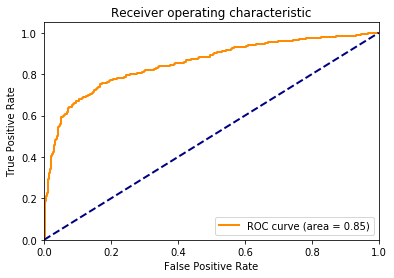

In [12]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()